# Smile Detection using Convolutional Neural Networks

In [1]:
# Inspired work from Kyle McDonald
# Project: https://github.com/kylemcdonald/SmileCNN

In [2]:
#util and imports
import os
import fnmatch
from cStringIO import StringIO
import numpy as np
import PIL.Image
import IPython.display
import shutil

def list_all_files(directory, extensions=None):
    for root, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            base, ext = os.path.splitext(filename)
            joined = os.path.join(root, filename)
            if extensions is None or ext.lower() in extensions:
                yield joined


def show_array(a, fmt='png', filename=None):
    a = np.uint8(np.clip(a, 0, 255))
    image_data = StringIO()
    PIL.Image.fromarray(a).save(image_data, fmt)
    if filename is None:
        IPython.display.display(IPython.display.Image(data=image_data.getvalue()))
    else:
        with open(filename, 'w') as f:
            image_data.seek(0)
            shutil.copyfileobj(image_data, f)

def find_rectangle(n, max_ratio=2):
    sides = []
    square = int(math.sqrt(n))
    for w in range(square, max_ratio * square):
        h = n / w
        used = w * h
        leftover = n - used
        sides.append((leftover, (w, h)))
    return sorted(sides)[0][1]

# should work for 1d and 2d images, assumes images are square but can be overriden
def make_mosaic(images, n=None, nx=None, ny=None, w=None, h=None):
    if n is None and nx is None and ny is None:
        nx, ny = find_rectangle(len(images))
    else:
        nx = n if nx is None else nx
        ny = n if ny is None else ny
    images = np.array(images)
    if images.ndim == 2:
        side = int(np.sqrt(len(images[0])))
        h = side if h is None else h
        w = side if w is None else w
        images = images.reshape(-1, h, w)
    else:
        h = images.shape[1]
        w = images.shape[2]
    image_gen = iter(images)
    mosaic = np.empty((h*ny, w*nx))
    for i in range(ny):
        ia = (i)*h
        ib = (i+1)*h
        for j in range(nx):
            ja = j*w
            jb = (j+1)*w
            mosaic[ia:ib, ja:jb] = next(image_gen)
    return mosaic

In [3]:
#Download dataset
!sudo apt-get install unzip
!wget https://github.com/hromi/SMILEsmileD/archive/master.zip
!unzip -q master.zip
!rm master.zip

/bin/sh: 1: sudo: not found
--2018-06-13 13:58:02--  https://github.com/hromi/SMILEsmileD/archive/master.zip
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/hromi/SMILEsmileD/zip/master [following]
--2018-06-13 13:58:02--  https://codeload.github.com/hromi/SMILEsmileD/zip/master
Resolving codeload.github.com (codeload.github.com)... 192.30.253.121, 192.30.253.120
Connecting to codeload.github.com (codeload.github.com)|192.30.253.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41620712 (40M) [application/zip]
Saving to: ‘master.zip.1’

master.zip.1        100%[===================>]  39.69M  18.5MB/s    in 2.2s    

2018-06-13 13:58:05 (18.5 MB/s) - ‘master.zip.1’ saved [41620712/41620712]

replace SMILEsmileD-master/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


UnboundLocalError: ignored

In [4]:
negative_paths = list(list_all_files('SMILEsmileD-master/SMILEs/negatives/negatives7/', ['.jpg']))
print 'loaded', len(negative_paths), 'negative examples'
positive_paths = list(list_all_files('SMILEsmileD-master/SMILEs/positives/positives7/', ['.jpg']))
print 'loaded', len(positive_paths), 'positive examples'
examples = [(path, 0) for path in negative_paths] + [(path, 1) for path in positive_paths]

loaded 9475 negative examples
loaded 3690 positive examples


In [5]:
!pip install -U scikit-image

Requirement already up-to-date: scikit-image in /usr/local/lib/python2.7/dist-packages (0.14.0)
Requirement not upgraded as not directly required: PyWavelets>=0.4.0 in /usr/local/lib/python2.7/dist-packages (from scikit-image) (0.5.2)
Requirement not upgraded as not directly required: scipy>=0.17.0 in /usr/local/lib/python2.7/dist-packages (from scikit-image) (0.19.1)
Requirement not upgraded as not directly required: six>=1.10.0 in /usr/local/lib/python2.7/dist-packages (from scikit-image) (1.11.0)
Requirement not upgraded as not directly required: networkx>=1.8 in /usr/local/lib/python2.7/dist-packages (from scikit-image) (2.1)
Requirement not upgraded as not directly required: matplotlib>=2.0.0 in /usr/local/lib/python2.7/dist-packages (from scikit-image) (2.1.2)
Requirement not upgraded as not directly required: dask[array]>=0.9.0 in /usr/local/lib/python2.7/dist-packages (from scikit-image) (0.17.5)
Requirement not upgraded as not directly required: cloudpickle>=0.2.1 in /usr/loca

In [6]:
import numpy as np
from skimage.measure import block_reduce
from skimage.io import imread

def examples_to_dataset(examples, block_size=2):
    X = []
    y = []
    for path, label in examples:
        img = imread(path, as_gray=True)
        img = block_reduce(img, block_size=(block_size, block_size), func=np.mean)
        img = img.reshape((32*32))
        X.append(img)
        if(label==0):
            y.append((1,0))
        else:
            y.append((0,1))
    return np.asarray(X), np.asarray(y)

X, Y = examples_to_dataset(examples)
X = np.asarray(X,dtype=np.float32)/ 255.
Y = np.asarray(Y,dtype=np.int32)
print X.dtype, X.min(), X.max(), X.shape

float32 0.0 1.0 (13165, 1024)


In [7]:
# Split data into train and test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=2)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


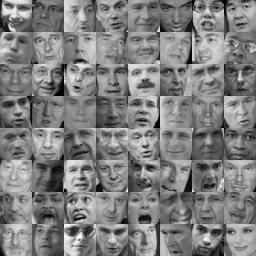

In [8]:
#show Negative images
show_array(255 * make_mosaic(X[:len(negative_paths)], 8), fmt='jpeg') # negative at the beginning

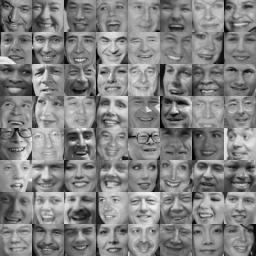

In [9]:
#show Positive images
show_array(255 * make_mosaic(X[-len(positive_paths):], 8), fmt='jpeg') # positive at the end

In [10]:
import tensorflow as tf

In [11]:
# Network Parameters
n_input = X.shape[1]
n_classes = 2 # (Smile vs. No Smile)
dropout = 0.75 # Dropout, probability to keep units

In [12]:
# Parameters
learning_rate = 0.001
training_iters = 8820
batch_size = 128
display_step = 10
training_epochs=200

In [13]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

In [14]:
# Create model
def conv2d(img, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w, strides=[1, 1, 1, 1], 
                                                  padding='SAME'),b))

def max_pool(img, k):
    return tf.nn.max_pool(img, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def conv_net(_X, _weights, _biases, _dropout):
    # Reshape input picture
    _X = tf.reshape(_X, shape=[-1, 32, 32, 1])

    # Convolution Layer
    conv1 = conv2d(_X, _weights['wc1'], _biases['bc1'])
    
    # Convolution Layer
    conv2 = conv2d(conv1, _weights['wc2'], _biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = max_pool(conv2, k=2)
    # Apply Dropout
    conv2 = tf.nn.dropout(conv2, _dropout)

    # Fully connected layer
    # Reshape conv2 output to fit dense layer input
    dense1 = tf.reshape(conv2, [-1, _weights['wd1'].get_shape().as_list()[0]]) 
    # Relu activation
    dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, _weights['wd1']), _biases['bd1']))
    # Apply Dropout
    dense1 = tf.nn.dropout(dense1, _dropout) # Apply Dropout

    # Output, class prediction
    out = tf.add(tf.matmul(dense1, _weights['out']), _biases['out'])
    return out

In [15]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 9],stddev=0.01)), 
    # 5x5 conv, 32 inputs, 32 outputs
    'wc2': tf.Variable(tf.truncated_normal([3, 3, 9, 9],stddev=0.01)), 
    # fully connected, 16*16*32 inputs, 1024 outputs
    'wd1': tf.Variable(tf.truncated_normal([16*16*9, 16],stddev=0.01)), 
    # 128 inputs, 2 outputs (class prediction)
    'out': tf.Variable(tf.truncated_normal([16, n_classes])) 
}

biases = {
    'bc1': tf.Variable(tf.random_normal([9])),
    'bc2': tf.Variable(tf.random_normal([9])),
    'bd1': tf.Variable(tf.random_normal([16])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [16]:
# Construct model
pred = conv_net(x, weights, biases, keep_prob)

In [18]:
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
#cost = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=pred, labels=y,pos_weight=10))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [19]:
# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [20]:
# Initializing the variables
init = tf.global_variables_initializer()

Epoch 0, Minibatch Loss= 0.611996, Training Accuracy= 0.71094


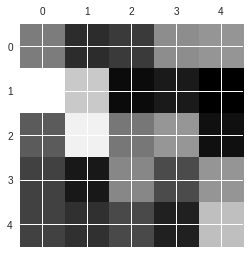

Epoch 1, Minibatch Loss= 0.607442, Training Accuracy= 0.71094
Epoch 2, Minibatch Loss= 0.605553, Training Accuracy= 0.71094
Epoch 3, Minibatch Loss= 0.607316, Training Accuracy= 0.71094
Epoch 4, Minibatch Loss= 0.612247, Training Accuracy= 0.71094
Epoch 5, Minibatch Loss= 0.608633, Training Accuracy= 0.71094
Epoch 6, Minibatch Loss= 0.605847, Training Accuracy= 0.71094
Epoch 7, Minibatch Loss= 0.603595, Training Accuracy= 0.71094
Epoch 8, Minibatch Loss= 0.602792, Training Accuracy= 0.71094
Epoch 9, Minibatch Loss= 0.603394, Training Accuracy= 0.71094
Epoch 10, Minibatch Loss= 0.462744, Training Accuracy= 0.77344
Epoch 11, Minibatch Loss= 0.439065, Training Accuracy= 0.81250
Epoch 12, Minibatch Loss= 0.433965, Training Accuracy= 0.81250
Epoch 13, Minibatch Loss= 0.409741, Training Accuracy= 0.82812
Epoch 14, Minibatch Loss= 0.362261, Training Accuracy= 0.84375
Epoch 15, Minibatch Loss= 0.349903, Training Accuracy= 0.85938
Epoch 16, Minibatch Loss= 0.341421, Training Accuracy= 0.82812
E

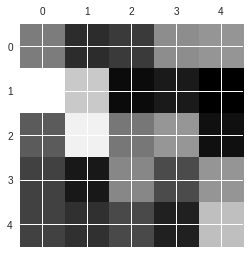

Epoch 51, Minibatch Loss= 0.261846, Training Accuracy= 0.88281
Epoch 52, Minibatch Loss= 0.244239, Training Accuracy= 0.88281
Epoch 53, Minibatch Loss= 0.257954, Training Accuracy= 0.88281
Epoch 54, Minibatch Loss= 0.245254, Training Accuracy= 0.88281
Epoch 55, Minibatch Loss= 0.251888, Training Accuracy= 0.88281
Epoch 56, Minibatch Loss= 0.256388, Training Accuracy= 0.89062
Epoch 57, Minibatch Loss= 0.238978, Training Accuracy= 0.89062
Epoch 58, Minibatch Loss= 0.263363, Training Accuracy= 0.88281
Epoch 59, Minibatch Loss= 0.251489, Training Accuracy= 0.88281
Epoch 60, Minibatch Loss= 0.258244, Training Accuracy= 0.89062
Epoch 61, Minibatch Loss= 0.252381, Training Accuracy= 0.88281
Epoch 62, Minibatch Loss= 0.238445, Training Accuracy= 0.89062
Epoch 63, Minibatch Loss= 0.243096, Training Accuracy= 0.88281
Epoch 64, Minibatch Loss= 0.233090, Training Accuracy= 0.89062
Epoch 65, Minibatch Loss= 0.235218, Training Accuracy= 0.89062
Epoch 66, Minibatch Loss= 0.236992, Training Accuracy= 

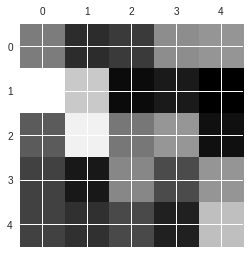

Epoch 101, Minibatch Loss= 0.191629, Training Accuracy= 0.90625
Epoch 102, Minibatch Loss= 0.189242, Training Accuracy= 0.90625
Epoch 103, Minibatch Loss= 0.189834, Training Accuracy= 0.91406
Epoch 104, Minibatch Loss= 0.177678, Training Accuracy= 0.92188
Epoch 105, Minibatch Loss= 0.182002, Training Accuracy= 0.91406
Epoch 106, Minibatch Loss= 0.185010, Training Accuracy= 0.90625
Epoch 107, Minibatch Loss= 0.185250, Training Accuracy= 0.92969
Epoch 108, Minibatch Loss= 0.180499, Training Accuracy= 0.92188
Epoch 109, Minibatch Loss= 0.177998, Training Accuracy= 0.92969
Epoch 110, Minibatch Loss= 0.179700, Training Accuracy= 0.92969
Epoch 111, Minibatch Loss= 0.186472, Training Accuracy= 0.93750
Epoch 112, Minibatch Loss= 0.178675, Training Accuracy= 0.92188
Epoch 113, Minibatch Loss= 0.188687, Training Accuracy= 0.92188
Epoch 114, Minibatch Loss= 0.183627, Training Accuracy= 0.91406
Epoch 115, Minibatch Loss= 0.173062, Training Accuracy= 0.92969
Epoch 116, Minibatch Loss= 0.178782, Tra

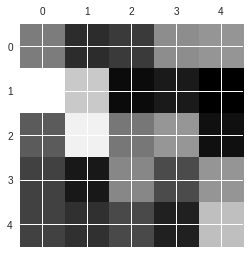

Epoch 151, Minibatch Loss= 0.164813, Training Accuracy= 0.93750
Epoch 152, Minibatch Loss= 0.152923, Training Accuracy= 0.92969
Epoch 153, Minibatch Loss= 0.151971, Training Accuracy= 0.92969
Epoch 154, Minibatch Loss= 0.153406, Training Accuracy= 0.92969
Epoch 155, Minibatch Loss= 0.157481, Training Accuracy= 0.93750
Epoch 156, Minibatch Loss= 0.151088, Training Accuracy= 0.93750
Epoch 157, Minibatch Loss= 0.158719, Training Accuracy= 0.92969
Epoch 158, Minibatch Loss= 0.147783, Training Accuracy= 0.93750
Epoch 159, Minibatch Loss= 0.149787, Training Accuracy= 0.93750
Epoch 160, Minibatch Loss= 0.160005, Training Accuracy= 0.93750
Epoch 161, Minibatch Loss= 0.151069, Training Accuracy= 0.92969
Epoch 162, Minibatch Loss= 0.155015, Training Accuracy= 0.93750
Epoch 163, Minibatch Loss= 0.149144, Training Accuracy= 0.93750
Epoch 164, Minibatch Loss= 0.160730, Training Accuracy= 0.93750
Epoch 165, Minibatch Loss= 0.148410, Training Accuracy= 0.93750
Epoch 166, Minibatch Loss= 0.152137, Tra

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
X_train = X_train.reshape(X_train.shape[0],1024)

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
  
    for epoch in range(training_epochs):
        step = 1
        # Keep training until reach max iterations
        while step * batch_size < training_iters:
            batch_xs, batch_ys = X_train[(batch_size*(step-1)):batch_size*(step)],y_train[(batch_size*(step-1)):batch_size*(step)]
            # Fit training using batch data
            sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
            step += 1
        # Calculate batch accuracy
        if(epoch%1 == 0):
            # Calculate batch loss
            acc,conv1filter = sess.run([accuracy,weights['wc1']], feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            loss = sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            print "Epoch " + str(epoch) + ", Minibatch Loss= " + \
                          "{:.6f}".format(loss) + ", Training Accuracy= " + "{:.5f}".format(acc)
        if(epoch%50 == 0):
            #acc = sess.run(accuracy, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            plt.figure()
            #plt.matshow(make_mosaic(conv1filter.reshape(9,32).T, 4),cmap="gray")
            plt.matshow(conv1filter[:,:,0,1],cmap="gray")
            plt.show()
            
            
    print "Optimization Finished!"
    # Calculate accuracy for 256 mnist test images
    print "Testing Accuracy:", sess.run(accuracy, feed_dict={x: X_test, 
                                                                 y: y_test, 
                                                                 keep_prob: 1.})

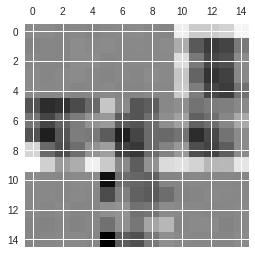

In [25]:
plt.figure()
plt.matshow(make_mosaic(conv1filter.reshape(25,9).T, 3),cmap="gray")
plt.show()